## Installing Ivy

Since we want the packages to be available after installing, after running the first two cells, the notebook will automatically restart.

In [140]:
!git clone https://github.com/unifyai/ivy.git
%cd ivy
!pip install --user -e .
!pip install colorama
!pip install huggingface_hub

In [141]:
!pip install -q dm-haiku
!git clone https://github.com/unifyai/models.git

# Using a stable commit from models repository to ensure compatibility with Ivy 😄
!cd models/ && pip install .

exit()

## Initialising Compiler API Key

Replace `API_KEY` with your API key

In [142]:
API_KEY = "API_KEY"
!mkdir -p .ivy
!echo -n $API_KEY > .ivy/key.pem

## Importing Ivy

In [143]:
import ivy

## Loading and preprocessing a sample image

In [144]:
filename = "horse.jpg"

In [145]:
# Loading the image
from PIL import Image
import numpy as np

img = Image.open(filename)
img = np.asarray(img)

In [160]:
# Preprocess the image
import tensorflow as tf
from tensorflow import keras
from keras import layers

def preprocess():
  transform = keras.Sequential([
                tf.keras.layers.experimental.preprocessing.Normalization(
                    mean=(0.5, 0.5, 0.5), variance=(0.25, 0.25, 0.25)
                ),
                tf.keras.layers.experimental.preprocessing.Resizing(72, 72),
            ]
        )
  return transform

prepoc = preprocess()
tf_img = prepoc(img)
tf_img = tf.expand_dims(tf_img, 0)

img = tf_img.numpy()

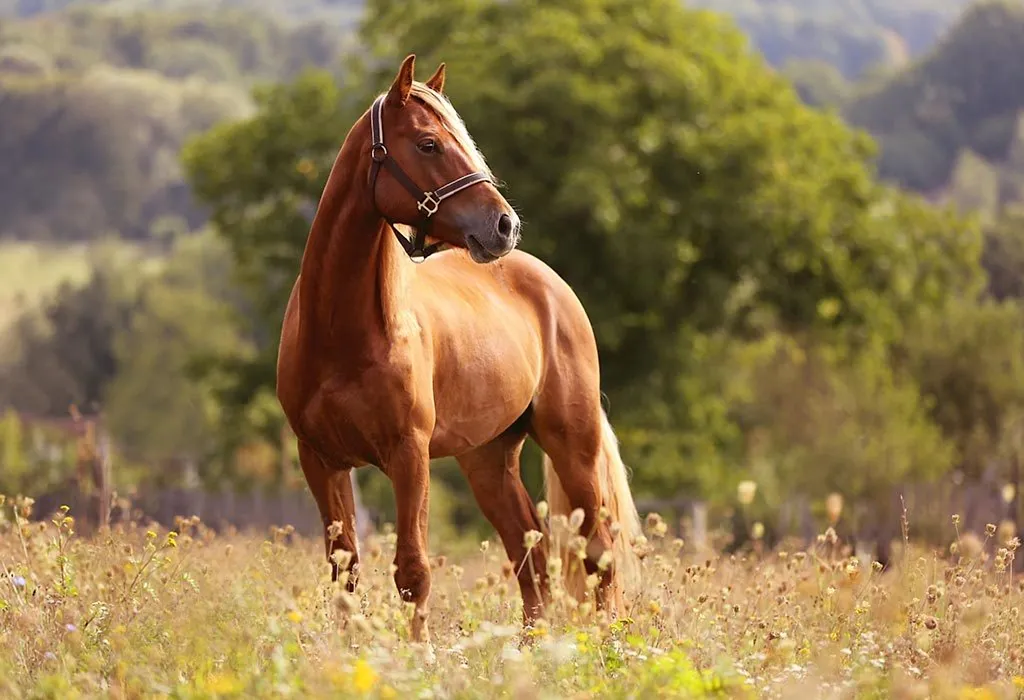

In [147]:
from IPython.display import Image, display
display(Image(filename))

In [148]:
# Getting the different classes in
categories = ['plane', 'automobile', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Ivy MLP Mixer Inference In Tensorflow

Here we import the [MLP Mixer Implementation](https://colab.research.google.com/drive/1ZidYr76_pCQNQskwxyyXa5qjuUVmseCd#scrollTo=clM2QrQX87hk&line=8&uniqifier=1) in Native Ivy.

In [149]:
import ivy
ivy.set_backend("tensorflow")

from ivy_models.mlpmixer import mlpmixer
ivy_mlpmixer = mlpmixer()

In order to make sure the model is as quick as possible, we can call ivy.compile(). This can take a moment, but is a one-time cost.

In [150]:
ivy_mlpmixer = ivy.compile(ivy_mlpmixer, args=(ivy.asarray(tf_img),))

In [152]:
# output = ivy.softmax(ivy_mlpmixer(ivy.asarray(tf_img)))  # pass the image to the model
output = ivy_mlpmixer(ivy.asarray(img))
classes = ivy.argsort(output[0], descending=True)[:3]  # get the top 3 classes
logits = ivy.gather(output[0], classes)  # get the logits

print("Indices of the top 3 classes are:", classes)
print("Logits of the top 3 classes are:", logits)
print("Categories of the top 3 classes are:", [categories[i] for i in classes.to_list()])

Indices of the top 3 classes are: ivy.array([7, 6, 9], dev=gpu:0)
Logits of the top 3 classes are: ivy.array([0.43874821, 0.12901554, 0.10044083], dev=gpu:0)
Categories of the top 3 classes are: ['horse', 'frog', 'truck']


## Pytorch Inference

Using the model with a PyTorch Backend

In [153]:
import ivy
import torch
ivy.set_backend("torch")

ivy_mlpmixer = mlpmixer()

Speeding up inference using `ivy.compile`

In [154]:
ivy_mlpmixer = ivy.compile(ivy_mlpmixer, args=(ivy.asarray(img),))

In [155]:
output = ivy_mlpmixer(ivy.asarray(img)) # pass the image to the model
classes = ivy.argsort(output[0], descending=True)[:3]  # get the top 3 classes
logits = ivy.gather(output[0], classes)  # get the logits

print("Indices of the top 3 classes are:", classes)
print("Logits of the top 3 classes are:", logits)
print("Categories of the top 3 classes are:", [categories[i] for i in classes.to_list()])

Indices of the top 3 classes are: ivy.array([3, 0, 7])
Logits of the top 3 classes are: ivy.array([0.5907377 , 0.18112788, 0.13967107])
Categories of the top 3 classes are: ['cat', 'plane', 'horse']


## Jax Inference

In [156]:
import jax
ivy.set_backend("jax")
ivy_mlpmixer = mlpmixer()

In [ ]:
ivy_mlpmixer = ivy.compile(ivy_mlpmixer, args=(ivy.asarray(img),))

In [158]:
output = ivy_mlpmixer(ivy.asarray(img))  # pass the image to the model
classes = ivy.argsort(output[0], descending=True)[:3]  # get the top 3 classes
logits = ivy.gather(output[0], classes)  # get the logits

print("Indices of the top 3 classes are:", classes)
print("Logits of the top 3 classes are:", logits)
print("Categories of the top 3 classes are:", [categories[i] for i in classes.to_list()])

Indices of the top 3 classes are: ivy.array([1, 0, 4], dev=gpu:0)
Logits of the top 3 classes are: ivy.array([0.37148738, 0.25912502, 0.17902127], dev=gpu:0)
Categories of the top 3 classes are: ['automobile', 'plane', 'deer']


## MLP Mixer Implementation

In [159]:
class MLPBlock(ivy.Module):
  def __init__(self,inp_dim,mlp_dim):
    self.linear0 = ivy.Linear(inp_dim,mlp_dim)
    self.gelu = ivy.GELU()
    self.linear1 = ivy.Linear(mlp_dim,inp_dim)
    self.dropout = ivy.Dropout(0.25)
    super(MLPBlock, self).__init__()

  def _forward(self,x):
    y = self.linear0(x)
    y = self.gelu(y)
    y = self.dropout(y)
    y = self.linear1(y)
    y = self.dropout(y)
    return y

class MixerBlock(ivy.Module):
  def __init__(self,hidden_dim,num_patches,token_mlp_dim,channel_mlp_dim):
    self.norm1 = ivy.LayerNorm([hidden_dim])
    self.mlp_block1 = MLPBlock(num_patches,token_mlp_dim)
    self.norm2 = ivy.LayerNorm([hidden_dim])
    self.mlp_block2 = MLPBlock(hidden_dim,channel_mlp_dim)
    super(MixerBlock, self).__init__()

  def _forward(self,x):
    y = self.norm1(x)
    y = ivy.matrix_transpose(y)
    y = self.mlp_block1(y)
    y = ivy.matrix_transpose(y)
    x = x + y
    y = self.norm2(x)
    y = x + self.mlp_block2(y)
    return y

class MLPMixer(ivy.Module):
  def __init__(self,vol,inp_dim,num_classes=10,num_blocks=2,patch_size=16,hidden_dim=128,token_mlp_dim=64,channel_mlp_dim=32):
    self.num_blocks = num_blocks
    self.conv = ivy.Conv2D(inp_dim,hidden_dim,[patch_size,patch_size],[patch_size,patch_size],0)
    self.num_patches = int((vol/patch_size)**2)
    self.mixer_block = MixerBlock(hidden_dim,self.num_patches,token_mlp_dim , channel_mlp_dim)
    self.norm = ivy.LayerNorm([hidden_dim])
    self.dropout = ivy.Dropout(0.25)
    self.linear = ivy.Linear(hidden_dim,num_classes)
    super(MLPMixer, self).__init__()

  def _forward(self,x):
    x = self.conv(x)
    x = x.reshape((int(x.shape[0]),int(x.shape[1])*int(x.shape[2]),int(x.shape[3])))
    for i in range(self.num_blocks):
      x = self.mixer_block(x)
    x = self.norm(x)
    x = self.dropout(x)
    x = ivy.mean(x,axis=1)
    logits = self.linear(x)
    probs = ivy.softmax(logits)

    return probs